# Data Ted
## Analisi dei Ted Talk
---
#### Matano Francesco S5253162
#### Vassallo Edoardo S4965918 
---

# Introduzione ed Obiettivi
> ### Abbiamo deciso di studiare l'andamento delle visual e dei like dei vari ted talk fatti <br> nel periodo di tempo compreso tra 1970 al 2022.

# 0. Preparativi
> ## Librerie importate


In [120]:
##LIB FOR UTIL THING
import os
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.metrics as metrics 
import re
##LIB FOR ML THING
import pandas as pd 
import scipy.stats as stats
import datetime as dt
import sklearn
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

> ## Funzioni utilizzate per il notebook

In [121]:
def print_stats_field(df, field):
    print("--------------------------------------------"   )
    print("Statistiche relative a:  ", field               )
    print("--------------------------------------------"   )
    print("Media:                   ",  df[field].mean()   )
    print("Moda:                    ",  df[field].mode()[0])
    print("Mediana:                 ",  df[field].median() )
    print("Varianza:                ",  df[field].var()    )
    print("Deviazione standard:     ",  df[field].std()    ) 
    print("--------------------------------------------"   )

In [122]:
def print_all_olap_on_first_dim(olap_df, xlabel, ylabel, list_of_labels):

    cols = (len(list_of_labels) // 2) + 1

    plt.figure(figsize=(10, 30))

    for element in range(0, len(list_of_labels)):
        plt.subplot(cols, 2, element+1)
        plt.title(list_of_labels[element])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.imshow(olap_df[element, :, :])
        plt.colorbar()

        for (j,i),label in np.ndenumerate(olap_df[element, :, :]):
            plt.text(i,j,label,ha='center',va='center')

    plt.show()

In [123]:
def print_ttest_1samp(first_dataset, second_dataset, column, name):
    t, p_value = stats.ttest_1samp(a = first_dataset[column].values, popmean= second_dataset[column].mean())
    print("\nt-test on ", name, ":")
    print('Valore test: ', t)
    print('P-value: ', p_value)

In [124]:
def print_chi_squared(obs, exp, name):
    chi_squared, p_value = stats.chisquare(f_obs= obs, f_exp = exp)
    print("\nt-test on ", name, ":")
    print('Chi-quadrato: ', chi_squared)
    print('P-value: ', p_value)

In [125]:
def cluster_df(df, x_label, y_label, z_label, n_cluster):
     scaler = preprocessing.MinMaxScaler()
     tmp = df[[x_label, y_label, z_label]]
     scaler.fit(tmp)
     scaled = scaler.fit_transform(tmp)
     scaled_df = pd.DataFrame(scaled, columns=tmp.columns)
     kmeans = KMeans(n_clusters= n_cluster, random_state=0, n_init='auto')
     kmeans.fit(scaled_df)
     fig = plt.figure()
     ax = plt.axes(projection ='3d')
     ax.scatter(tmp[x_label].values, tmp[y_label].values, tmp[z_label].values, c = kmeans.labels_, alpha=0.5)
     #create_3d_plot_gif(ax, fig)
     return silhouette_score(scaled_df, kmeans.labels_)


In [126]:
def create_3d_plot(xy_struct, z_struct, x_label, y_label, lin_reg, plt):
    ###Create x, y surface meshgrid
    x_surf, y_surf = np.meshgrid(
                                  np.linspace(xy_struct[x_label].min(), xy_struct[x_label].max(), 100),
                                  np.linspace(xy_struct[y_label].min(), xy_struct[y_label].max(), 100)
                                )

    onlyX = pd.DataFrame({x_label : x_surf.ravel(), y_label: y_surf.ravel()})
    fittedY = np.array(lin_reg.predict(onlyX))
    z_pred = lin_reg.predict(xy_struct)

    print('Score:', lin_reg.score(xy_valid, z_valid))
    
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), color='green', alpha=0.3)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_struct, color='red', alpha=0.7)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_pred)
    ax.set_title('Piano di predizione e dati di training')
    # create_3d_plot_gif(ax, fig)
    plt.show()
    return z_pred


In [127]:
def create_3d_plot_gif(ax, fig):
    # DA INSTALLARE PER LA GENERAZIONE DELLE GIF
    import imageio.v2 as imageio # pip install imageio
    from natsort import natsorted # pip install natsort

    png_dir = 'gif_production/resources'
    images = []

    # generiamo i frame
    for ii in np.arange(0, 360, 1):
          ax.view_init(elev=32, azim=ii)
          fig.savefig('gif_production/resources/frame_%d.png' % ii)

    # generiamo la gif
    for file_name in natsorted(os.listdir(png_dir)):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

    # Make it pause at the end so that the viewers can ponder
    for _ in range(10):
        images.append(imageio.imread(file_path))

    imageio.mimsave('gif_production/gif/movie.gif', images, fps=120)


> ##  Definizione di array globali utilizzati all'interno del notebook
<u> N.B. Dopo varie prove, abbiamo visto che ci conveniva quantizzare la variabile data dei vari anni d'usicta dei ted talk per un intervallo di 2 anni per poter effettuare un'analisi migliore dei dati contenuti nel dataset. <br>
Inoltre abbiamo deciso di raggruppare tutti i ted talk fatti dal 1970 al 2000 in un unico gruppo per poter avere abbastanza dati da analizzare in seguito su quel gruppo.</u>

In [128]:
#quantizzazione delle date
quantize_date  = [(str(element)[2:4] + 's') for element in range(2000, 2022, 2)]
quantize_date.insert(0, 'pre-00s')

#quantizzazione dell views
quantize_views = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '1M-20M', '>20M'  ]
#quantizzazione dei likes
quantize_likes = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '>1M'             ]

---

> ## Import Dataset

In [129]:
daTed = pd.read_csv("data_ted.csv")
daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


# 1. Pulizia Dati

Analizzando i nostri dati, abbiamo ritrovato i seguenti errori:

1. È presente una riga con autore mancante

In [130]:
print(daTed.loc[(daTed['author'].isnull())])

                   title author           date  views  likes  \
3039  Year In Ideas 2015    NaN  December 2015    532     15   

                                          link  
3039  https://ted.com/talks/year_in_ideas_2015  


2. Due delle righe presenti vengono erroneamente datati al gennaio 1970, data sospetta in quanto valore minimo dei timestamp UNIX.<br> L'errore è stato verificato cercando i video in questione online.

In [131]:
print(daTed.loc[(daTed['date'] == 'January 1970')])

                                 title          author          date   views  \
736               Innovations in sleep      Beautyrest  January 1970   60000   
738  Love letters to what we hold dear  Debbie Millman  January 1970  192000   

     likes                                               link  
736   1800  https://ted.com/talks/beautyrest_innovations_i...  
738   5700  https://ted.com/talks/debbie_millman_love_lett...  


Siccome questi errori riguardano solo un paio di righe, si è deciso di correggere le righe, invece che eliminarle, nel seguente modo:

1. Vedendo [il video in questione](https://www.ted.com/talks/year_in_ideas_2015) si è visto che si tratta di un video celebrativo realizzato dall'azienda stessa. Si è deciso quindi di attribuirlo all'autore *"TED"*.

In [132]:
daTed.loc[(daTed['author'].isnull()), 'author'] = 'TED'
print(daTed.loc[(daTed['author'].isnull())])

Empty DataFrame
Columns: [title, author, date, views, likes, link]
Index: []


2. Similmente, possiamo rintracciare la data di pubblicazione dei video online *"Innovations in sleep"* è stato [caricato](https://youtu.be/mo264ECPacQ?si=O2mQA_2kww7flGm3) sulla pagina Youtube di TED nel Luglio 2020.<br>  *"Love letters to what we hold dear"* è stato presentato nel corso di TED2020.<br> Cercando la [scaletta](https://tedlive.ted.com/webcasts/t2020/session/419) dell'evento, scopriamo che è stato presentato nel Giugno di quell'anno.

In [133]:
daTed.loc[(daTed['title'] == 'Innovations in sleep'),              'date'] = 'July 2020'
daTed.loc[(daTed['title'] == 'Love letters to what we hold dear'), 'date'] = 'June 2020'

print(daTed.loc[(daTed['date'] == 'January 1970')])

Empty DataFrame
Columns: [title, author, date, views, likes, link]
Index: []


L'ultima correzione necessaria è al **formato delle date**. <br>
Al momento la data di pubblicazione è memorizzata come una stringa mese-anno. <br>Decidiamo di tradurla nel tipo *datetime*, per aiutare in seguito.

In [134]:
daTed["date"] = pd.to_datetime(daTed['date'], format='%B %Y')

# 2. Visualizzazione dei dati

La nostra analisi si basa principalmente sullo studio dell'evoluzione temporale dei dati.<br> Cominciamo quindi mostrando un grafico del numero di uscite rispetto all'anno.

<Axes: title={'center': 'Numero di Video per Anno'}, xlabel='Anno', ylabel='N° Video'>

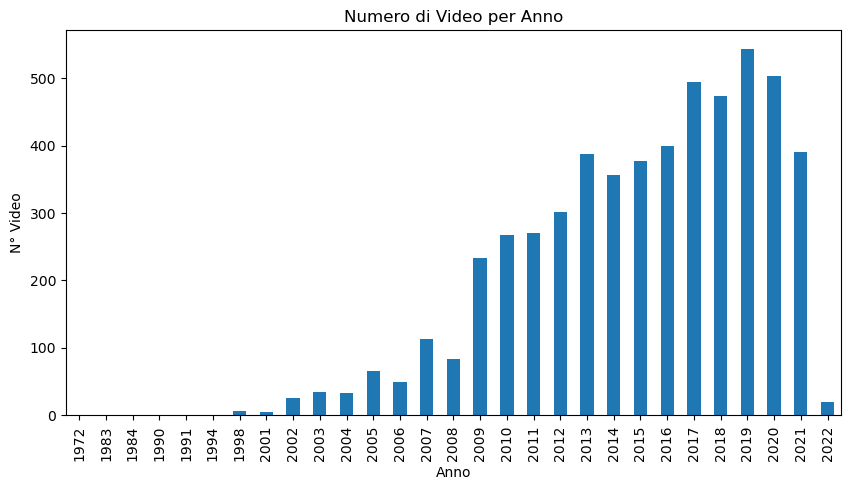

In [135]:
daTed.groupby(daTed.date.dt.year)['title'].count().plot( kind    = 'bar', 
                                                         figsize = (10,5), 
                                                         ylabel  = "N° Video", 
                                                         xlabel  = "Anno", 
                                                         title   = "Numero di Video per Anno" )

Possiamo quindi notare un *trend*, la crescita del numero di video nel corso degli anni.

Vediamo ora di studiare la **qualità** di questi video, sulla base dei valori di like e visualizzazioni. Realizziamo a tal scopo, un **OLAP** ad hoc, **quantizzando** le colonne dei likes, views, e data di pubblicazione.

In [136]:
# Quantizzazione per decade
# p.s max date 2022
daTed.loc[daTed['date'].between(pd.to_datetime("1970", format='%Y'), pd.to_datetime("2000", format='%Y'), 'both'), 'date_quant'] = quantize_date[0]

daTed.loc[daTed['date'].between(pd.to_datetime("2000", format='%Y'), pd.to_datetime("2002", format='%Y'), 'both'), 'date_quant'] = quantize_date[1]
daTed.loc[daTed['date'].between(pd.to_datetime("2002", format='%Y'), pd.to_datetime("2004", format='%Y'), 'both'), 'date_quant'] = quantize_date[2]
daTed.loc[daTed['date'].between(pd.to_datetime("2004", format='%Y'), pd.to_datetime("2006", format='%Y'), 'both'), 'date_quant'] = quantize_date[3]
daTed.loc[daTed['date'].between(pd.to_datetime("2006", format='%Y'), pd.to_datetime("2008", format='%Y'), 'both'), 'date_quant'] = quantize_date[4]
daTed.loc[daTed['date'].between(pd.to_datetime("2008", format='%Y'), pd.to_datetime("2010", format='%Y'), 'both'), 'date_quant'] = quantize_date[5]
daTed.loc[daTed['date'].between(pd.to_datetime("2010", format='%Y'), pd.to_datetime("2012", format='%Y'), 'both'), 'date_quant'] = quantize_date[6]
daTed.loc[daTed['date'].between(pd.to_datetime("2012", format='%Y'), pd.to_datetime("2014", format='%Y'), 'both'), 'date_quant'] = quantize_date[7]
daTed.loc[daTed['date'].between(pd.to_datetime("2014", format='%Y'), pd.to_datetime("2016", format='%Y'), 'both'), 'date_quant'] = quantize_date[8]
daTed.loc[daTed['date'].between(pd.to_datetime("2016", format='%Y'), pd.to_datetime("2018", format='%Y'), 'both'), 'date_quant'] = quantize_date[9]
daTed.loc[daTed['date'].between(pd.to_datetime("2018", format='%Y'), pd.to_datetime("2020", format='%Y'), 'both'), 'date_quant'] = quantize_date[10]
daTed.loc[daTed['date'].between(pd.to_datetime("2020", format='%Y'), pd.to_datetime("2023", format='%Y'), 'both'), 'date_quant'] = quantize_date[11]


# Quantizzazione per quantità di views
## p.s. max views: 72M

daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
daTed.loc[daTed['views'].between(10000    , 99999   , 'both'), 'views_quant'] = quantize_views[1]
daTed.loc[daTed['views'].between(100000   , 499999  , 'both'), 'views_quant'] = quantize_views[2]
daTed.loc[daTed['views'].between(500000   , 999999  , 'both'), 'views_quant'] = quantize_views[3]
daTed.loc[daTed['views'].between(1000000  , 19999999, 'both'), 'views_quant'] = quantize_views[4]
daTed.loc[daTed['views'].between(20000000 , 80000000, 'both'), 'views_quant'] = quantize_views[5]

# Quantizzazione per quantità di likes
## p.s. max likes: 2.1M

daTed.loc[daTed['likes'].between(0       , 9999    , 'both'), 'likes_quant'] = quantize_likes[0]
daTed.loc[daTed['likes'].between(10000   , 99999   , 'both'), 'likes_quant'] = quantize_likes[1]
daTed.loc[daTed['likes'].between(100000  , 499999  , 'both'), 'likes_quant'] = quantize_likes[2]
daTed.loc[daTed['likes'].between(500000  , 999999  , 'both'), 'likes_quant'] = quantize_likes[3]
daTed.loc[daTed['likes'].between(1000000 , 10000000, 'both'), 'likes_quant'] = quantize_likes[4]

daTed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        5440 non-null   object        
 1   author       5440 non-null   object        
 2   date         5440 non-null   datetime64[ns]
 3   views        5440 non-null   int64         
 4   likes        5440 non-null   int64         
 5   link         5440 non-null   object        
 6   date_quant   5440 non-null   object        
 7   views_quant  5440 non-null   object        
 8   likes_quant  5440 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 382.6+ KB


/tmp/ipykernel_2646/803116214.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pre-00s' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  daTed.loc[daTed['date'].between(pd.to_datetime("1970", format='%Y'), pd.to_datetime("2000", format='%Y'), 'both'), 'date_quant'] = quantize_date[0]
/tmp/ipykernel_2646/803116214.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<10K' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
/tmp/ipykernel_2646/803116214.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<10K' has dtype incompatible with float64, please explicitly cast to a compatible dtype first

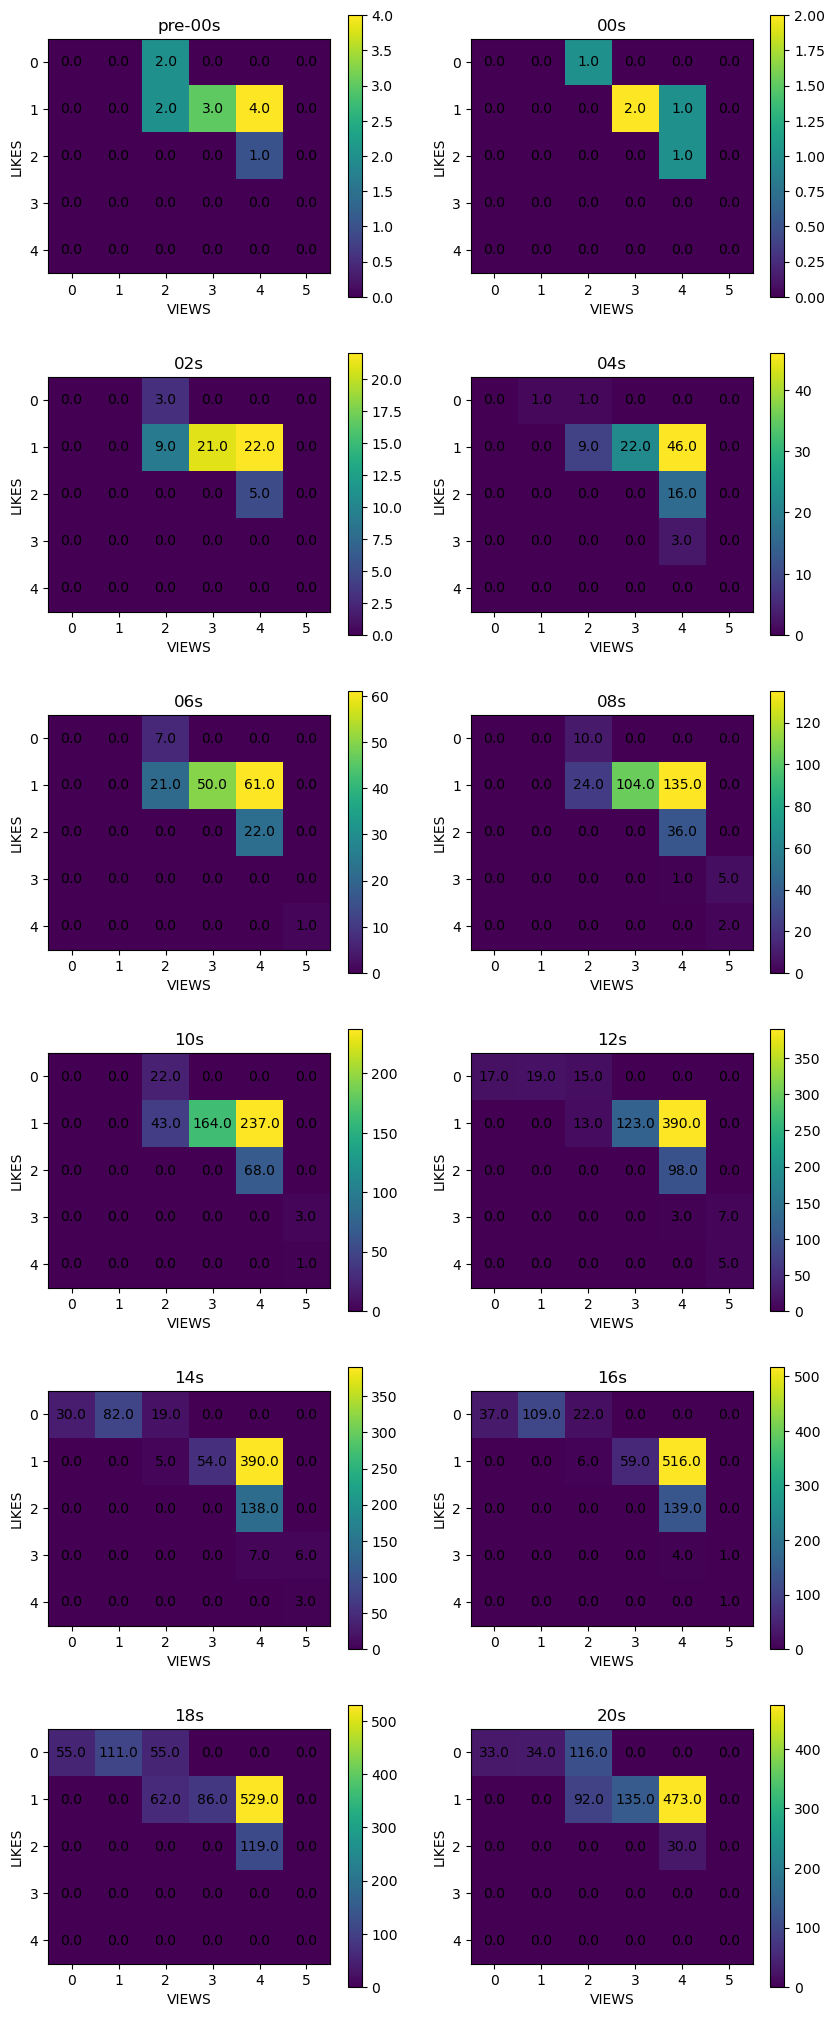

In [137]:
##OLAP che ha come dimensioni: x: le date quantizzate, y: le views quantizzate e z: il numero di like quantizzati
OLAP  = np.zeros((len(quantize_date), len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    views_class = daTed[daTed['views_quant'] == quantize_views[z]]
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_date)):
            OLAP[x,y,z] = np.sum(
                                (views_class['likes_quant'] == quantize_likes[y]) & 
                                (views_class['date_quant']  == quantize_date[x] ) )

print_all_olap_on_first_dim(OLAP, "VIEWS", "LIKES", quantize_date)

Dagli OLAP stampati qui sopra possiamo vedere che: la maggior parte dei video sono stati pubblicati negli anni 2010-2019 e che quasi tutti si trovino nella stessa classe di visualizzazioni e like (1M-20M visualizzazioni e 10K-100K like).

In [138]:
# A TIP:
# potremmo quantizzare sulla base della deviazione standard e media in 
# "valori bassi, valori  meno della media, valori  più della media, valori  alti"
print_stats_field(daTed, 'views')
print_stats_field(daTed, 'likes') 

--------------------------------------------
Statistiche relative a:   views
--------------------------------------------
Media:                    2061575.9579044117
Moda:                     1300000
Mediana:                  1300000.0
Varianza:                 12724186465893.252
Deviazione standard:      3567097.765115676
--------------------------------------------
--------------------------------------------
Statistiche relative a:   likes
--------------------------------------------
Media:                    62607.616727941175
Moda:                     39000
Mediana:                  40500.0
Varianza:                 11587826975.425608
Deviazione standard:      107646.76946116687
--------------------------------------------


Dal seguente grafico si può dedurre una correlazione tra il numero di views di un video con il suo numero di like.

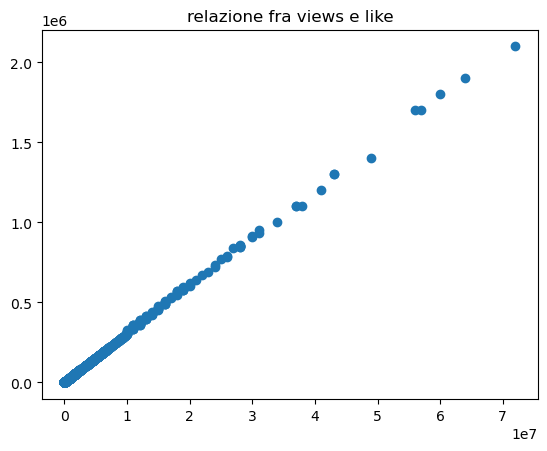

In [139]:
plt.title("relazione fra views e like")
plt.scatter(daTed["views"], daTed["likes"])

Calcolando covarianza e correlazione, la loro relazione appare ancora più ovvia

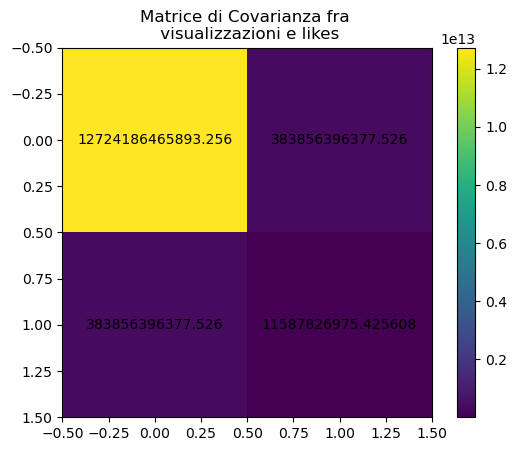

In [140]:
# matrice di covarianza

cov_matrix = daTed[["views", "likes"]].cov()
plt.imshow(cov_matrix)
plt.title("Matrice di Covarianza fra \n visualizzazioni e likes")
plt.colorbar()
for (j,i),label in np.ndenumerate(cov_matrix):
    plt.text(i,j,label,ha='center',va='center')

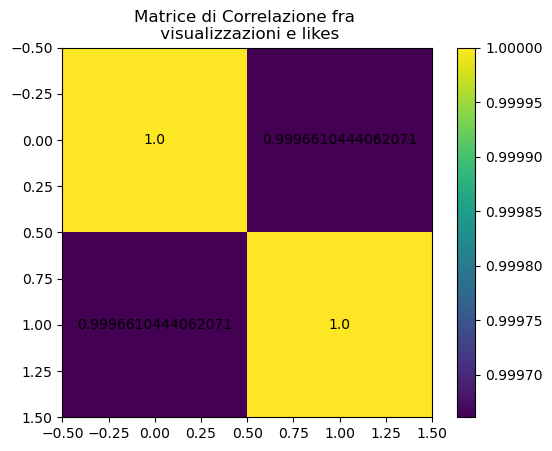

In [141]:
# matrice di correlazione

corr_matrix = daTed[["views", "likes",]].corr()
plt.title("Matrice di Correlazione fra \n visualizzazioni e likes")
plt.imshow(corr_matrix)
plt.colorbar()

for (j,i),label in np.ndenumerate(corr_matrix):
    plt.text(i,j,label,ha='center',va='center')

# 3. Test Statistici

## T-TEST

#####  Ipotesi: ipotizziamo che la media delle views ottenute nei vari bienni sia simile alla media totale delle view dei dati presenti nel dataset (e che quindi non possa esistere un ipotesi alternativa). </u>

<Axes: title={'center': 'views'}, xlabel='date_quant'>

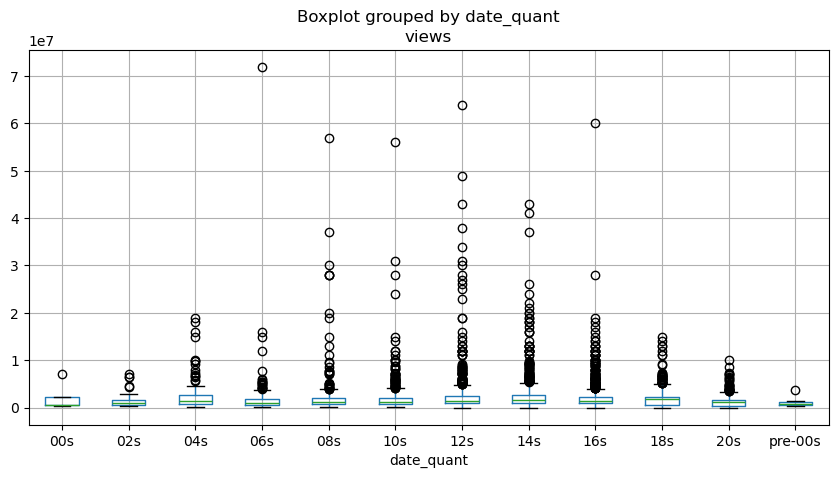

In [142]:
daTed.boxplot(column = "views", by = "date_quant", figsize=(10, 5))

Come si può notare dai boxplot qui sopra sono presenti molti outliers nelle decadi: 00's, 10's e 20's.
Considerando che queste sono le decadi con il maggior numero di dati ci aspettiamo anche una varianza complessiva motlo  alta.

In [143]:
popolazione = len(daTed)

for x in range(len(quantize_date)):
    campione =  len(daTed.loc[daTed["date_quant"] == quantize_date[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
            print_ttest_1samp(daTed.loc[daTed["date_quant"] == quantize_date[x]], daTed, "views", quantize_date[x])



t-test on  02s :
Valore test:  -3.3677977798037397
P-value:  0.0013390800115242174

t-test on  04s :
Valore test:  1.8310745689138235
P-value:  0.07015921996096157

t-test on  06s :
Valore test:  0.31395470734671327
P-value:  0.7539618614348842

t-test on  08s :
Valore test:  1.1968241495207987
P-value:  0.2322722161043237

t-test on  10s :
Valore test:  -0.06319540458669191
P-value:  0.9496344195331337


Come si può notare dai risultati ottenuti dai ttest svolti, si può vedere come, a meno del caso dei TED degli anni 2002-2004, non possiamo rifiutare il caso della ipotesi nulla (in quanto negli altri casi in cui è possibile fare il ttest ci vengono fuori dei p-value che sono maggiori del nostro livello di significatività che è di 0.05).<br>

####  Risultato: non possiamo dire che esiste una ipotesi alternativa a quella nulla.
Si può vedere dalla stampa della varie medie dei dati qui seguente

In [144]:
print("Media di tutto il dataset", daTed['views'].mean())

for x in range(len(quantize_date)):
    campione =  len(daTed.loc[daTed["date_quant"] == quantize_date[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
        print("Media anno", quantize_date[x], ": ", daTed.loc[daTed["date_quant"] == quantize_date[x]]['views'].mean())


Media di tutto il dataset 2061575.9579044117
Media anno 02s :  1413933.3333333333
Media anno 04s :  2753632.6428571427
Media anno 06s :  2208401.2283950616
Media anno 08s :  2415277.5993690854
Media anno 10s :  2051717.468401487


## TEST CHI-QUADRO

#### ipotesi: ipotizziamo che dati i grafici visti prima, esista una corrispondenza tra numero di views e likes in un ted talks.

In [145]:
chi_square = np.zeros((len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_date)):
            chi_square[y,z] += OLAP[x, y, z]
res =  stats.chi2_contingency(chi_square)
# TIP : Provare a fare il confronto fra vaolore ottenuto dal test
# e tabella del chi quadro
print("Risultato della nostra contigency test: ", res.pvalue)

Risultato della nostra contigency test:  0.0


#### Il risultato ottenuto dal nostro test del chi-quadro conferma ciò

# 4. Modello predittivo

### Proviamo a predire data una data il numero di views e like di un video.

Score: 0.9992605601358914


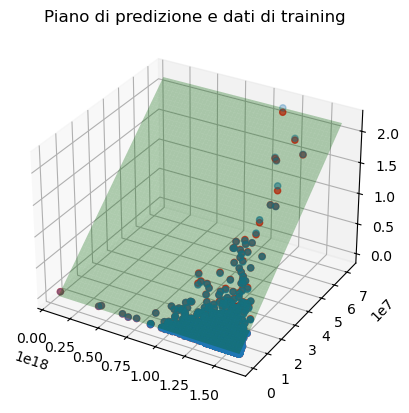

In [146]:
# DA FARE
# Forse predirre qualcosa di più complesso? 
# (siccome, data la correlazione fra like e views, viene un 
#  modello molto buono)

xy_train, xy_valid, z_train, z_valid = train_test_split(daTed[['date', 'views']], daTed['likes'], test_size=0.2, random_state=1)

# tradotto in numeri per poter fare la regressione
xy_train["date"] = xy_train["date"].values.astype(float)
xy_valid["date"] = xy_valid["date"].values.astype(float)

z_train = z_train.values
z_valid = z_valid.values

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)


z_pred_train = create_3d_plot(xy_train, z_train, "date", "views", lin_reg, plt)


# segue z = ax + by + c
# z_hat = x_train * lin_reg.coef_[0] + y_train * lin_reg.coef_[1] + lin_reg.intercept_


Score: 0.9992605601358914


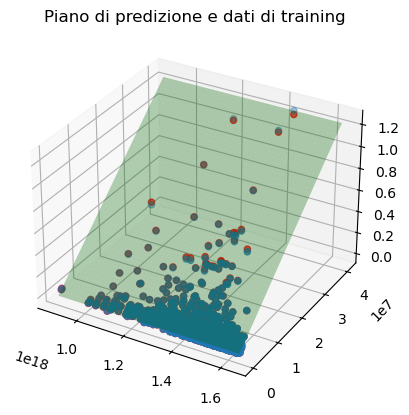

In [147]:
# segue z = ax + by + c
# z_hat = x_train * lin_reg.coef_[0] + y_train * lin_reg.coef_[1] + lin_reg.intercept_

z_pred_valid = create_3d_plot(xy_valid, z_valid, "date", "views", lin_reg, plt)

In [148]:

print ('MAE:',  metrics.mean_absolute_error(z_valid, z_pred_valid))
print ('MSE:',  metrics.mean_squared_error(z_valid, z_pred_valid))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(z_valid, z_pred_valid)))

MAE: 1152.287179466049
MSE: 8034853.998544703
RMSE: 2834.5818031139447


### Versione con il modello nullo

In [149]:
# Idea: osservo se il mio modello di predizione è più efficace (errore più basso) 
# di un modello nullo in cui si tira a caso sempre la media

#calcolate lo score medio
mean_likes = xy_valid['views'].mean()

# create la nuova x con lo stesso numero di campioni del validation set originale, 
# e con tutti i valori uguali al valore medio dello score appena calcolato
null_model_y = [mean_likes] * xy_valid['views'].shape[0]

#stampate gli errori
print ('MAE:', metrics.mean_absolute_error(xy_valid['views'], null_model_y))
print ('MSE:', metrics.mean_squared_error(xy_valid['views'], null_model_y))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(xy_valid['views'], null_model_y)))

MAE: 1745883.0642689634
MSE: 11808525886038.516
RMSE: 3436353.574072161


Da questi risultati possiamo vedere come tutte le seguenti misure: MAE (errore medio assoluto), MSE (errore quadratico medio) e RMSE (radice dell'errore quadratico medio) del modello nullo siano di gran nulli magggiori rispetto a quello in cui si tira a caso la media.<br>
Ciò significa che il nostro modello di predizione ottenuto è più efficace rispetto ad un modello in cui non esiste un metodo di predizione vero e proprio ma si tira solamente a caso prendendo solo in considerazione la media.

### TEST REGRESSIONE DATA -> VIEWS, LIKES

Score: 0.0113312311058964


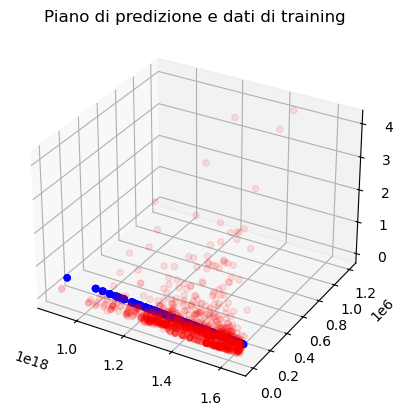

In [150]:
x_train, x_valid, yz_train, yz_valid = train_test_split(daTed[['date']], daTed[['likes', 'views']], test_size=0.2, random_state=1)

# tradotto in numeri per poter fare la regressione
x_train = x_train.values.astype(float)
x_valid = x_valid.values.astype(float)

regressor = LinearRegression()
lin_reg = regressor.fit(x_train, yz_train)

yz_pred = lin_reg.predict(x_valid)
print('Score:', lin_reg.score(x_valid, yz_valid))
y_label = "likes"
z_label = "views"

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x_valid, yz_pred[:,0], yz_pred[:,1], color='blue', alpha=0.9)
ax.scatter(x_valid, yz_valid[y_label].values, yz_valid[z_label].values, color='red', alpha=0.1)
ax.set_title('Piano di predizione e dati di training')
# create_3d_plot_gif(ax, fig)
plt.show()

### TEST REGRESSION VIEWS, LIKES -> DATA

Score: 0.011730292928266994


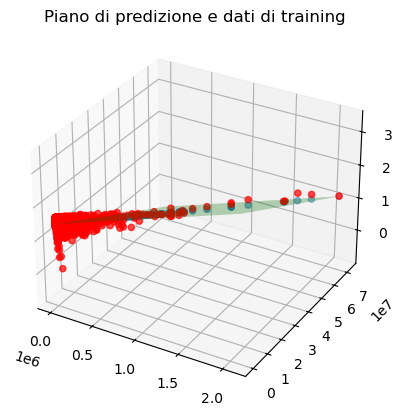

In [151]:
# DA FARE
# Forse predirre qualcosa di più complesso? 
# (siccome, data la correlazione fra like e views, viene un 
#  modello molto buono)

xy_train, xy_valid, z_train, z_valid = train_test_split(daTed[['likes', 'views']], daTed['date'], test_size=0.2, random_state=1)

# tradotto in numeri per poter fare la regressione
z_train = z_train.values.astype(float)
z_valid = z_valid.values.astype(float)

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)


z_pred_train = create_3d_plot(xy_train, z_train, "likes", "views", lin_reg, plt)


# segue z = ax + by + c
# z_hat = x_train * lin_reg.coef_[0] + y_train * lin_reg.coef_[1] + lin_reg.intercept_

# 5. Clustering (normalizzazione)

#### Nomalizzazione dei dati

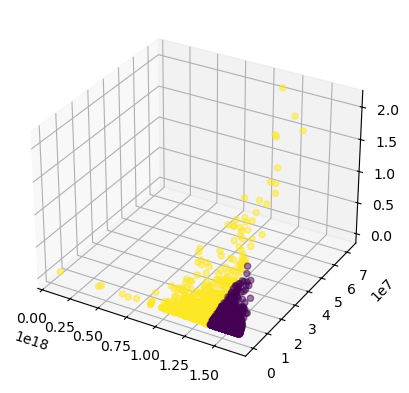

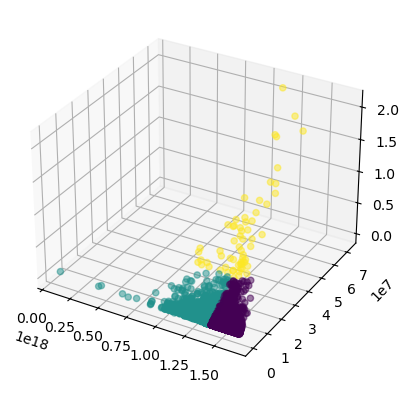

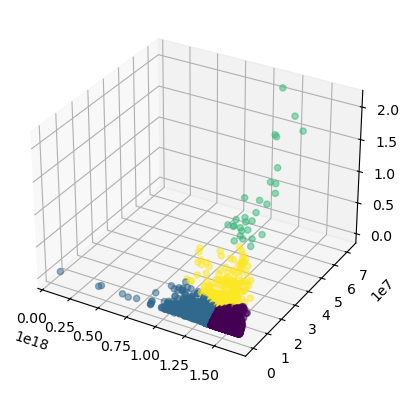

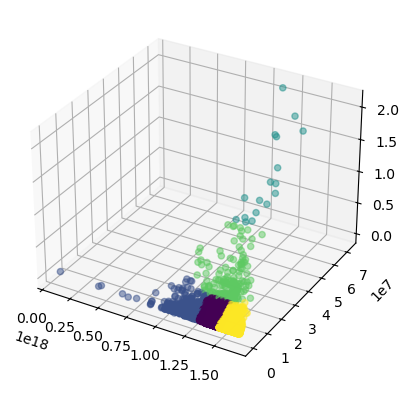

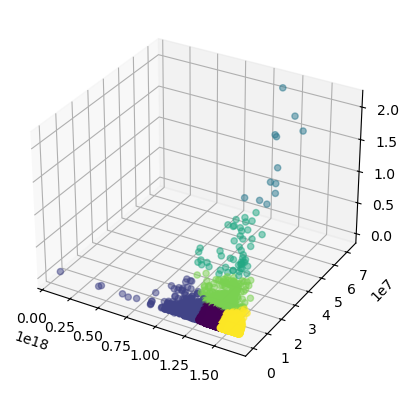

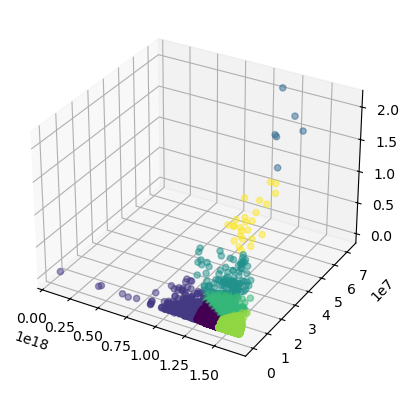

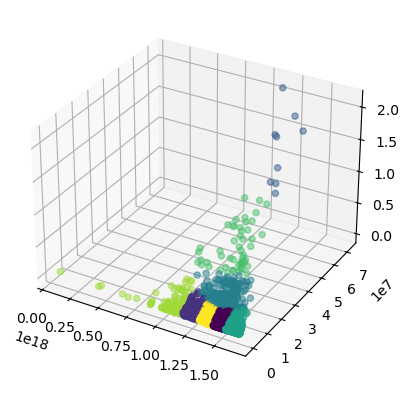

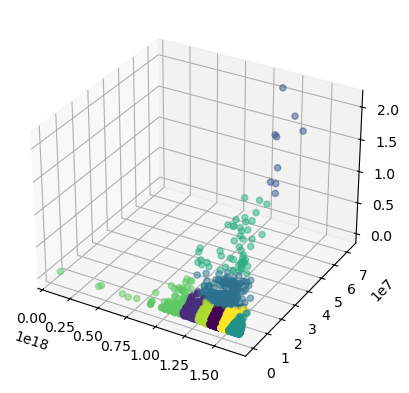

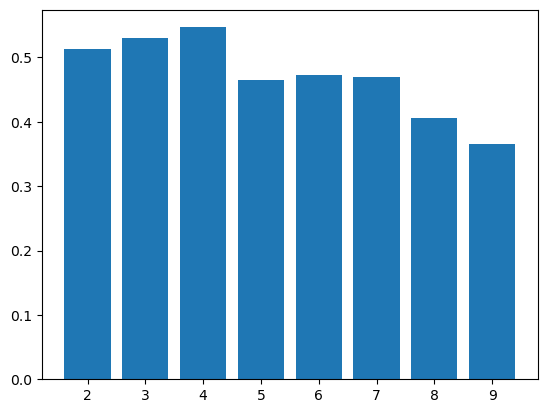

In [162]:
daTed['date'] = daTed['date'].astype(int)

arr_sil = [(cluster_df(daTed, 'date', 'views', 'likes', 4)) for k in range(2,10)]

fig = plt.figure()
plt.bar(range(2, 10), arr_sil)
plt.show()